In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
import numpy as np
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import Layout, CouplingMap
from qiskit.transpiler.passes import TrivialLayout, OptimizeSwapBeforeMeasure
from weylchamber import c1c2c3

In [ ]:
# define a mock topology and mock circuit
# line_topo = CouplingMap().from_grid(4,4)
# circ = QuantumCircuit(16)
# from qiskit.circuit.library import QuantumVolume
# circ = QuantumVolume(16, seed=42)

N = 4
# line_topo = CouplingMap().from_line(N)
# line_topo = CouplingMap().from_grid(3,4)
# line_topo = CouplingMap().from_line(N)
line_topo = CouplingMap().from_grid(2,2)
circ = QuantumCircuit(N)

# # # randomly generate CXs
# for i in range(100):
#     q1 = np.random.randint(N)
#     q2 = np.random.randint(N)
#     if q1 != q2:
#         circ.cx(q1, q2)

# circ.cx(5,6)
# # circ.cx(5,9)
# circ.cx(6,9)
# # circ.cx(2,6)
# circ.cx(2,5)
# circ.cx(4,6)
# circ.cx(5,7)
circ.ccx(0,1,2)
circ.u(0.1, 0.2, 0.3, 2)
circ.cx(1,2)
circ.u(0.1, 0.2, 0.3, 1)
circ.u(0.1, 0.2, 0.3, 2)
circ.cx(0,2)
circ.cx(0,1)
circ.u(0.1, 0.2, 0.3, 1)
circ.u(0.1, 0.2, 0.3, 2)
circ.cx(0,1)
circ.cx(1,2)
circ.u(0.1, 0.2, 0.3, 0)
circ.u(0.1, 0.2, 0.3, 2)
circ.cx(0,2)
circ.u(0.1, 0.2, 0.3, 2)


# transpile into CX basis
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
pm = PassManager(Unroller(['u', 'cx', 'swap']))
circ = pm.run(circ)
circ.draw()

»
q_0: ────────────────────────────────────■────────────────────────────────────»
                                         │                      ┌────────────┐»
q_1: ────────────────■───────────────────┼──────────────────■───┤ U(0,0,π/4) ├»
     ┌────────────┐┌─┴─┐┌─────────────┐┌─┴─┐┌────────────┐┌─┴─┐┌┴────────────┤»
q_2: ┤ U(π/2,0,π) ├┤ X ├┤ U(0,0,-π/4) ├┤ X ├┤ U(0,0,π/4) ├┤ X ├┤ U(0,0,-π/4) ├»
     └────────────┘└───┘└─────────────┘└───┘└────────────┘└───┘└─────────────┘»
q_3: ─────────────────────────────────────────────────────────────────────────»
                                                                              »
«                         ┌────────────┐                       »
«q_0: ──■────────■────────┤ U(0,0,π/4) ├────────■──────────────»
«       │      ┌─┴─┐     ┌┴────────────┤      ┌─┴─┐            »
«q_1: ──┼──────┤ X ├─────┤ U(0,0,-π/4) ├──────┤ X ├─────────■──»
«     ┌─┴─┐┌───┴───┴────┐└┬────────────┤┌─────┴───┴──────┐┌─┴─┐»
«q_2: ┤ X ├┤ U(0,0,π/4) ├─┤ U(π/2,0,π) ├┤ U(0.1,0.2,0.3) ├┤ X ├»
«     └───┘└────────────┘ └────────────┘└────────────────┘└───┘»
«q_3: ─────────────────────────────────────────────────────────»
«                                                              »
«                                                                     »
«q_0: ────────────────────■──────────■─────────────────────────────■──»
«     ┌────────────────┐  │        ┌─┴─┐       ┌────────────────┐┌─┴─┐»
«q_1: ┤ U(0.1,0.2,0.3) ├──┼────────┤ X ├───────┤ U(0.1,0.2,0.3) ├┤ X ├»
«     ├────────────────┤┌─┴─┐┌─────┴───┴──────┐└────────────────┘└───┘»
«q_2: ┤ U(0.1,0.2,0.3) ├┤ X ├┤ U(0.1,0.2,0.3) ├───────────────────────»
«     └────────────────┘└───┘└────────────────┘                       »
«q_3: ────────────────────────────────────────────────────────────────»
«                                                                     »
«     ┌────────────────┐                                         
«q_0: ┤ U(0.1,0.2,0.3) ├────────────────────■────────────────────
«     └────────────────┘                    │                    
«q_1: ────────■─────────────────────────────┼────────────────────
«           ┌─┴─┐       ┌────────────────┐┌─┴─┐┌────────────────┐
«q_2: ──────┤ X ├───────┤ U(0.1,0.2,0.3) ├┤ X ├┤ U(0.1,0.2,0.3) ├
«           └───┘       └────────────────┘└───┘└────────────────┘
«q_3: ───────────────────────────────────────────────────────────
«

In [ ]:
# line_topo.draw()

In [ ]:
# define a transpiler transformation pass
from qiskit.circuit.library import RZGate, HGate, iSwapGate, SwapGate
from qiskit.dagcircuit import DAGOpNode

class CNSSubstitution(TransformationPass):
    """Substitute CX+SWAP with iSwap"""
    def __init__(self):
        super().__init__()

    def run(self, dag):
        visited = []
        temp_dag = dag.copy_empty_like()
        for node in dag.topological_op_nodes():
            # if node is a CX
            if len(node.qargs)==2 and (node.name == 'cx' or c1c2c3(Operator(node.op).data) == (0.5, 0.0, 0.0)):

                # if followed by SWAP operation
                suc = list(dag.successors(node))
                
                # if more than one successor, skip
                # means not a CX+SWAP
                if len(suc) > 1:
                    # add node to temp_dag
                    temp_dag.apply_operation_back(node.op, node.qargs)
                    continue 
                suc = suc[0]

                # check that still an op node
                if not isinstance(suc, DAGOpNode):
                    continue
                
                # check that successor is SWAP and on same qubits
                if len(suc.qargs)==2 and (suc.name == 'swap' or c1c2c3(Operator(node.op).data)==(0.5, 0.5, 0.5)) and set(suc.qargs) == set(node.qargs): #set bc order doesn't matter
                    # substitute with iSwap identity
                    # temp_dag.apply_operation_back(RZGate(-np.pi/2), node.qargs[:1])
                    # temp_dag.apply_operation_back(HGate(), node.qargs[1:])
                    # temp_dag.apply_operation_back(RZGate(-np.pi/2), node.qargs[1:])
                    temp_dag.apply_operation_back(iSwapGate(), node.qargs)
                    # temp_dag.apply_operation_back(HGate(), node.qargs[:1])
                                      
                    # mark SWAP as visited
                    visited.append(suc)

                # otherwise, add node to temp_dag
                else:
                    temp_dag.apply_operation_back(node.op, node.qargs)

            # otherwise, add node to temp_dag
            else:
                # if node is a SWAP, check if it has been visited
                if len(node.qargs)==2 and (node.name == 'swap' or c1c2c3(Operator(node.op).data)==(0.5, 0.5, 0.5)) and node in visited:
                    continue
                temp_dag.apply_operation_back(node.op, node.qargs)
        return temp_dag

In [ ]:
# define a transpiler transformation pass
class VSwapSubstitution(TransformationPass):
    """Substitute CX with iSwap+VSwap"""
    def __init__(self):
        super().__init__()

    def run(self, dag):
        temp_dag = dag.copy_empty_like()
        layout_dict = {qubit: qubit for qubit in dag.qubits}

        for node in dag.topological_op_nodes():
            # if node is a CX, substitute with iSwap+VSwap
            # and update layout_dict
            qargs = [layout_dict[q] for q in node.qargs]
            if len(qargs)==2 and (node.name == 'cx' or c1c2c3(Operator(node.op).data)==(0.5, 0.0, 0.0)):

                # temp_dag.apply_operation_back(self.sub, qargs)
                # temp_dag.apply_operation_back(RZGate(-np.pi/2), qargs[:1])
                # temp_dag.apply_operation_back(HGate(), qargs[1:])
                # temp_dag.apply_operation_back(RZGate(-np.pi/2), qargs[1:])
                temp_dag.apply_operation_back(iSwapGate(), qargs)
                # temp_dag.apply_operation_back(HGate(), qargs[:1])

                # swap qubits in layout_dict
                layout_dict[node.qargs[1]], layout_dict[node.qargs[0]] = qargs

            # otherwise, add node to temp_dag using layout_dict
            else:
                temp_dag.apply_operation_back(node.op, qargs)

        # # for semantic accuracy, apply SWAPs so measurements are in the same order
        # # XXX there is probably a better way to do this
        # for qubit in dag.qubits:
        #     if layout_dict[qubit] != qubit:
        #         # get location, value in dict where qubit is
        #         loc = [k for k,v in layout_dict.items() if v == qubit][0]
        #         temp_dag.apply_operation_back(SwapGate(), [qubit, loc])
        #         # update layout_dict
        #         layout_dict[loc] = layout_dict[qubit]
        #         layout_dict[qubit] = qubit
                
        return temp_dag

In [ ]:
# # run the pass, on top of the line topology
# # start with trivial layout
# # pm = PassManager(passes=[TrivialLayout(line_topo), CNSSubstitution()])
# pm = PassManager(passes=[TrivialLayout(line_topo), VSwapSubstitution()])
# transp = pm.run(circ)
# transp.draw()

In [ ]:
# # statevector simulator to confirm correctness
# # expect to see the same when simulate circ and transp
# from qiskit import Aer, execute
# backend = Aer.get_backend('statevector_simulator')
# job = execute(circ, backend)
# result = job.result()
# s1 = result.get_statevector(circ)

# job = execute(transp, backend)
# result = job.result()
# s2 = result.get_statevector(transp)

# # assert statevectors are same up to global phase
# s1.equiv(s2, rtol=1e-8)

In [ ]:
# # induce baseline SWAPs
# from qiskit.transpiler.passes import BasicSwap
# pm = PassManager(passes=[TrivialLayout(line_topo), BasicSwap(line_topo), OptimizeSwapBeforeMeasure()])
# transp = pm.run(circ)
# print('Number of SWAPs in baseline:', len([node for node in transp if node.operation.name == 'swap']))
# transp.draw(output='mpl')

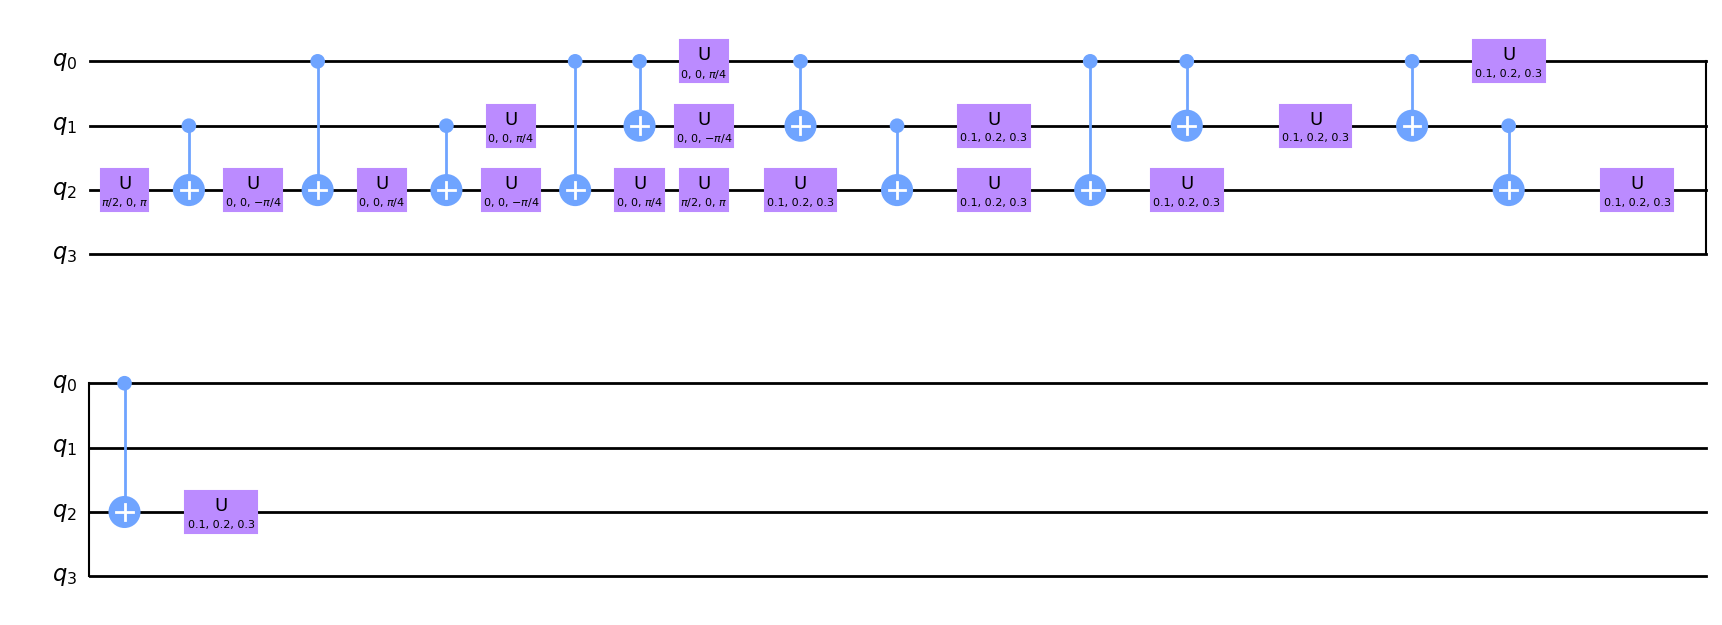

In [ ]:
circ.draw(output='mpl')

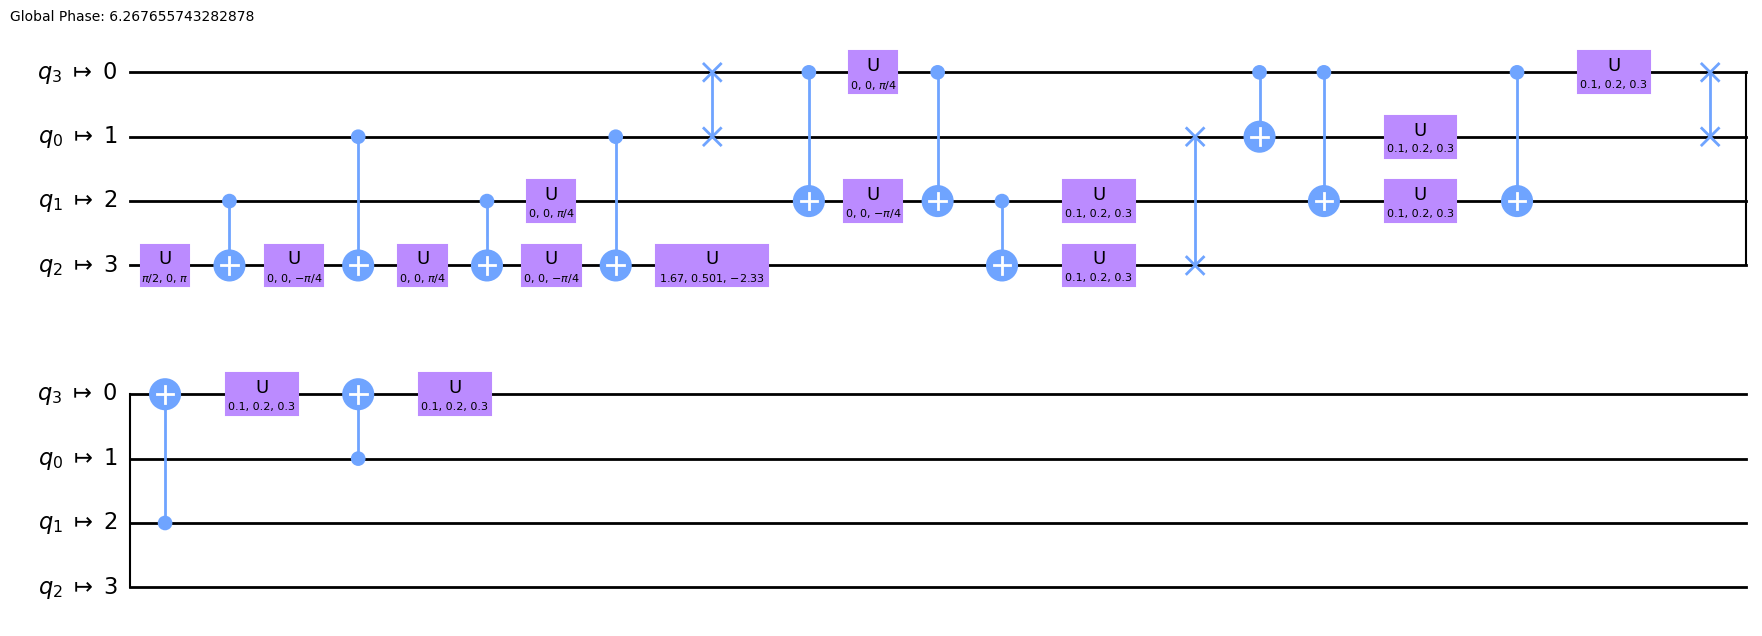

In [ ]:
from qiskit import transpile
bb = transpile(circ, basis_gates=['u', 'cx', 'swap'], coupling_map=line_topo, optimization_level=3)
bb.draw(output='mpl')

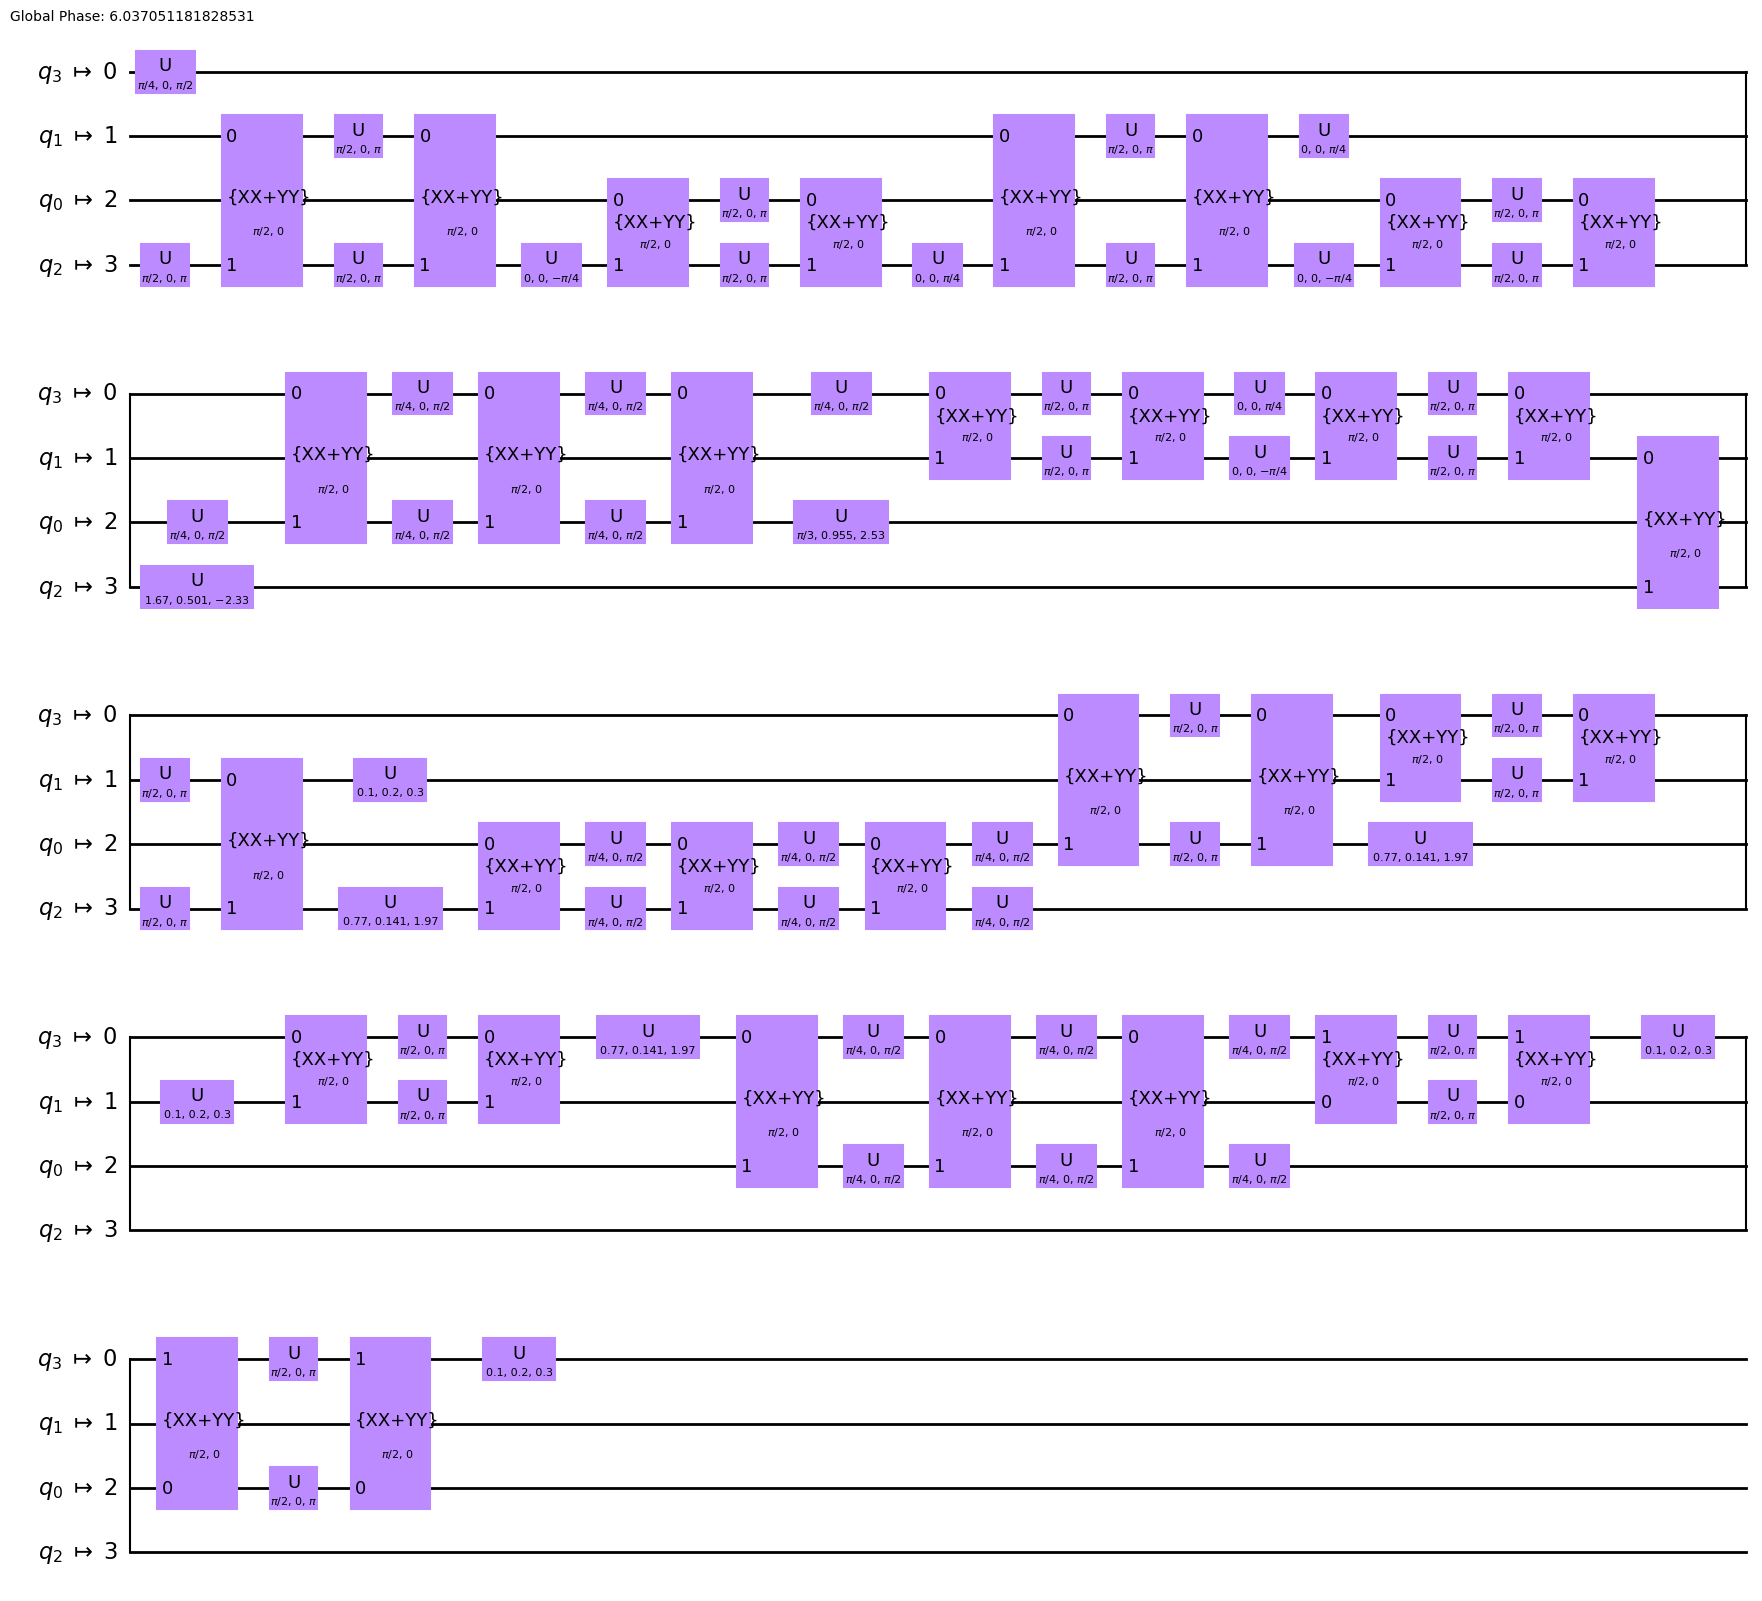

In [32]:
# from qiskit import BackendV2
from qiskit.providers import BackendV2
# Add any custom gates for the backend’s basis to the session EquivalenceLibrary instance.
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.circuit.library.standard_gates import CXGate, XXPlusYYGate
cx_decomp = QuantumCircuit(2)
cx_decomp.u(np.pi/4, 0, np.pi/2, 0)
cx_decomp.u(np.pi/4, 0, np.pi/2, 1)
cx_decomp.append(XXPlusYYGate(np.pi/2, 0), [0, 1])
cx_decomp.u(np.pi/4, 0, np.pi/2, 0)
cx_decomp.u(np.pi/4, 0, np.pi/2, 1)
cx_decomp.append(XXPlusYYGate(np.pi/2), [0, 1])
cx_decomp.u(np.pi/4, 0, np.pi/2, 0)
cx_decomp.u(np.pi/4, 0, np.pi/2, 1)
sel.add_equivalence(CXGate(), cx_decomp)

swap_decomp = QuantumCircuit(2)
swap_decomp.u(np.pi/4, 0, np.pi/2, 0)
swap_decomp.u(np.pi/4, 0, np.pi/2, 1)
swap_decomp.append(XXPlusYYGate(np.pi/2, 0), [0, 1])
swap_decomp.u(np.pi/4, 0, np.pi/2, 0)
swap_decomp.u(np.pi/4, 0, np.pi/2, 1)
swap_decomp.append(XXPlusYYGate(np.pi/2), [0, 1])
swap_decomp.u(np.pi/4, 0, np.pi/2, 0)
swap_decomp.u(np.pi/4, 0, np.pi/2, 1)
swap_decomp.append(XXPlusYYGate(np.pi/2), [0, 1])
swap_decomp.u(np.pi/4, 0, np.pi/2, 0)
swap_decomp.u(np.pi/4, 0, np.pi/2, 1)
sel.add_equivalence(SwapGate(), swap_decomp)

bb = transpile(circ, basis_gates=['u', 'xx_plus_yy'], coupling_map=line_topo, optimization_level=3)
bb.draw(output='mpl')

In [33]:
# draw the dag
from qiskit.converters import circuit_to_dag
dag = circuit_to_dag(circ)
dag.draw()
# save as png
dag.draw(filename='dag.png')

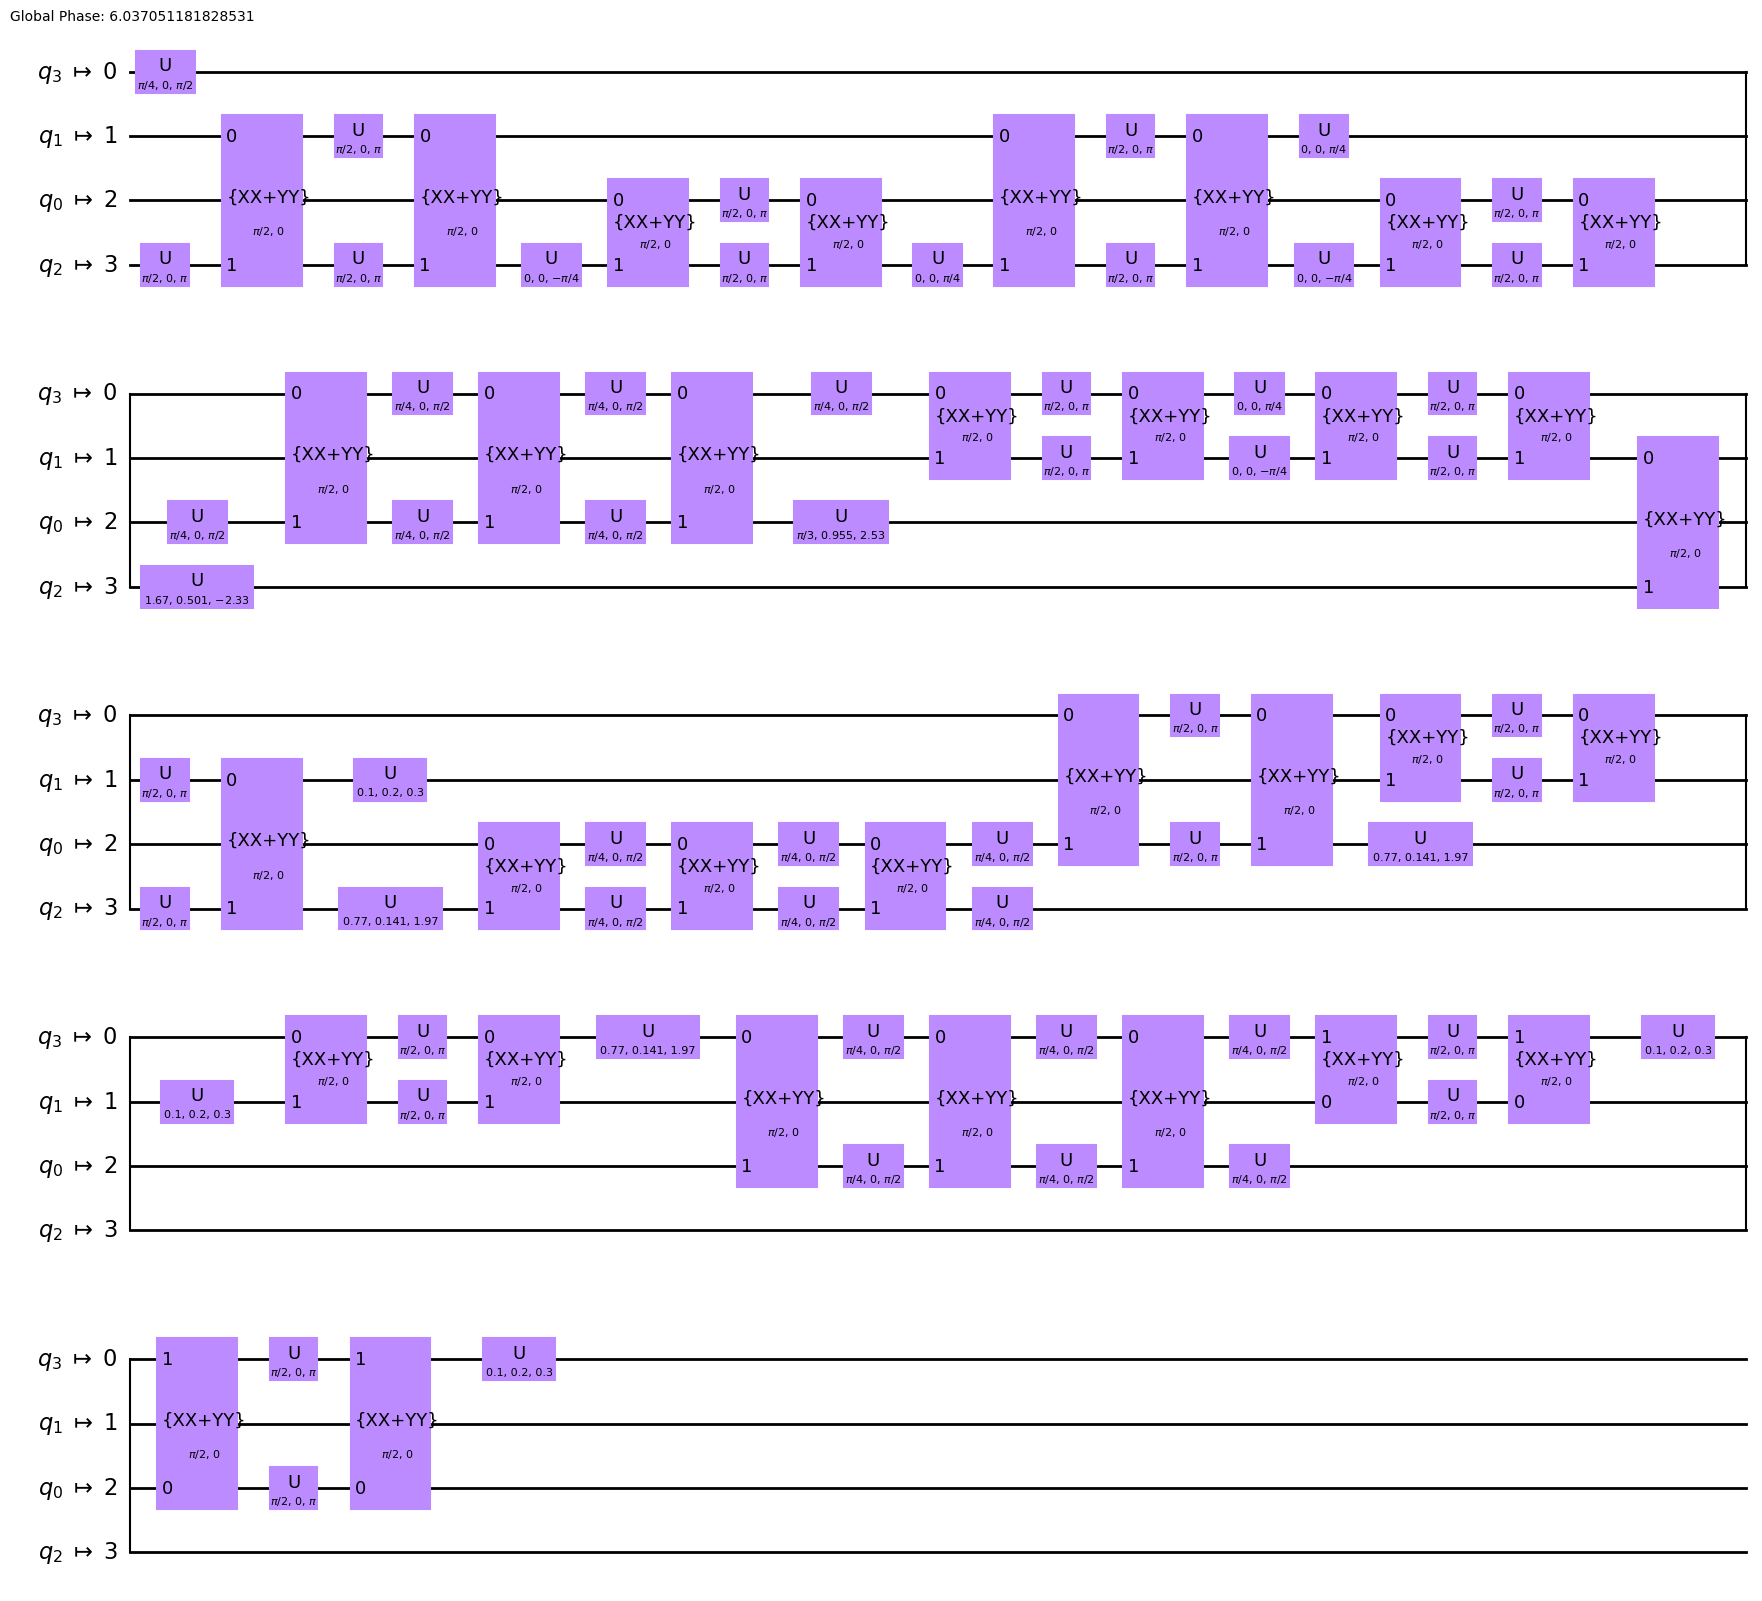

In [35]:
from qiskit import transpile
bb = transpile(circ, basis_gates=['u', 'xx_plus_yy'], coupling_map=line_topo, optimization_level=3)
bb.draw(output='mpl')

Number of operations: 33


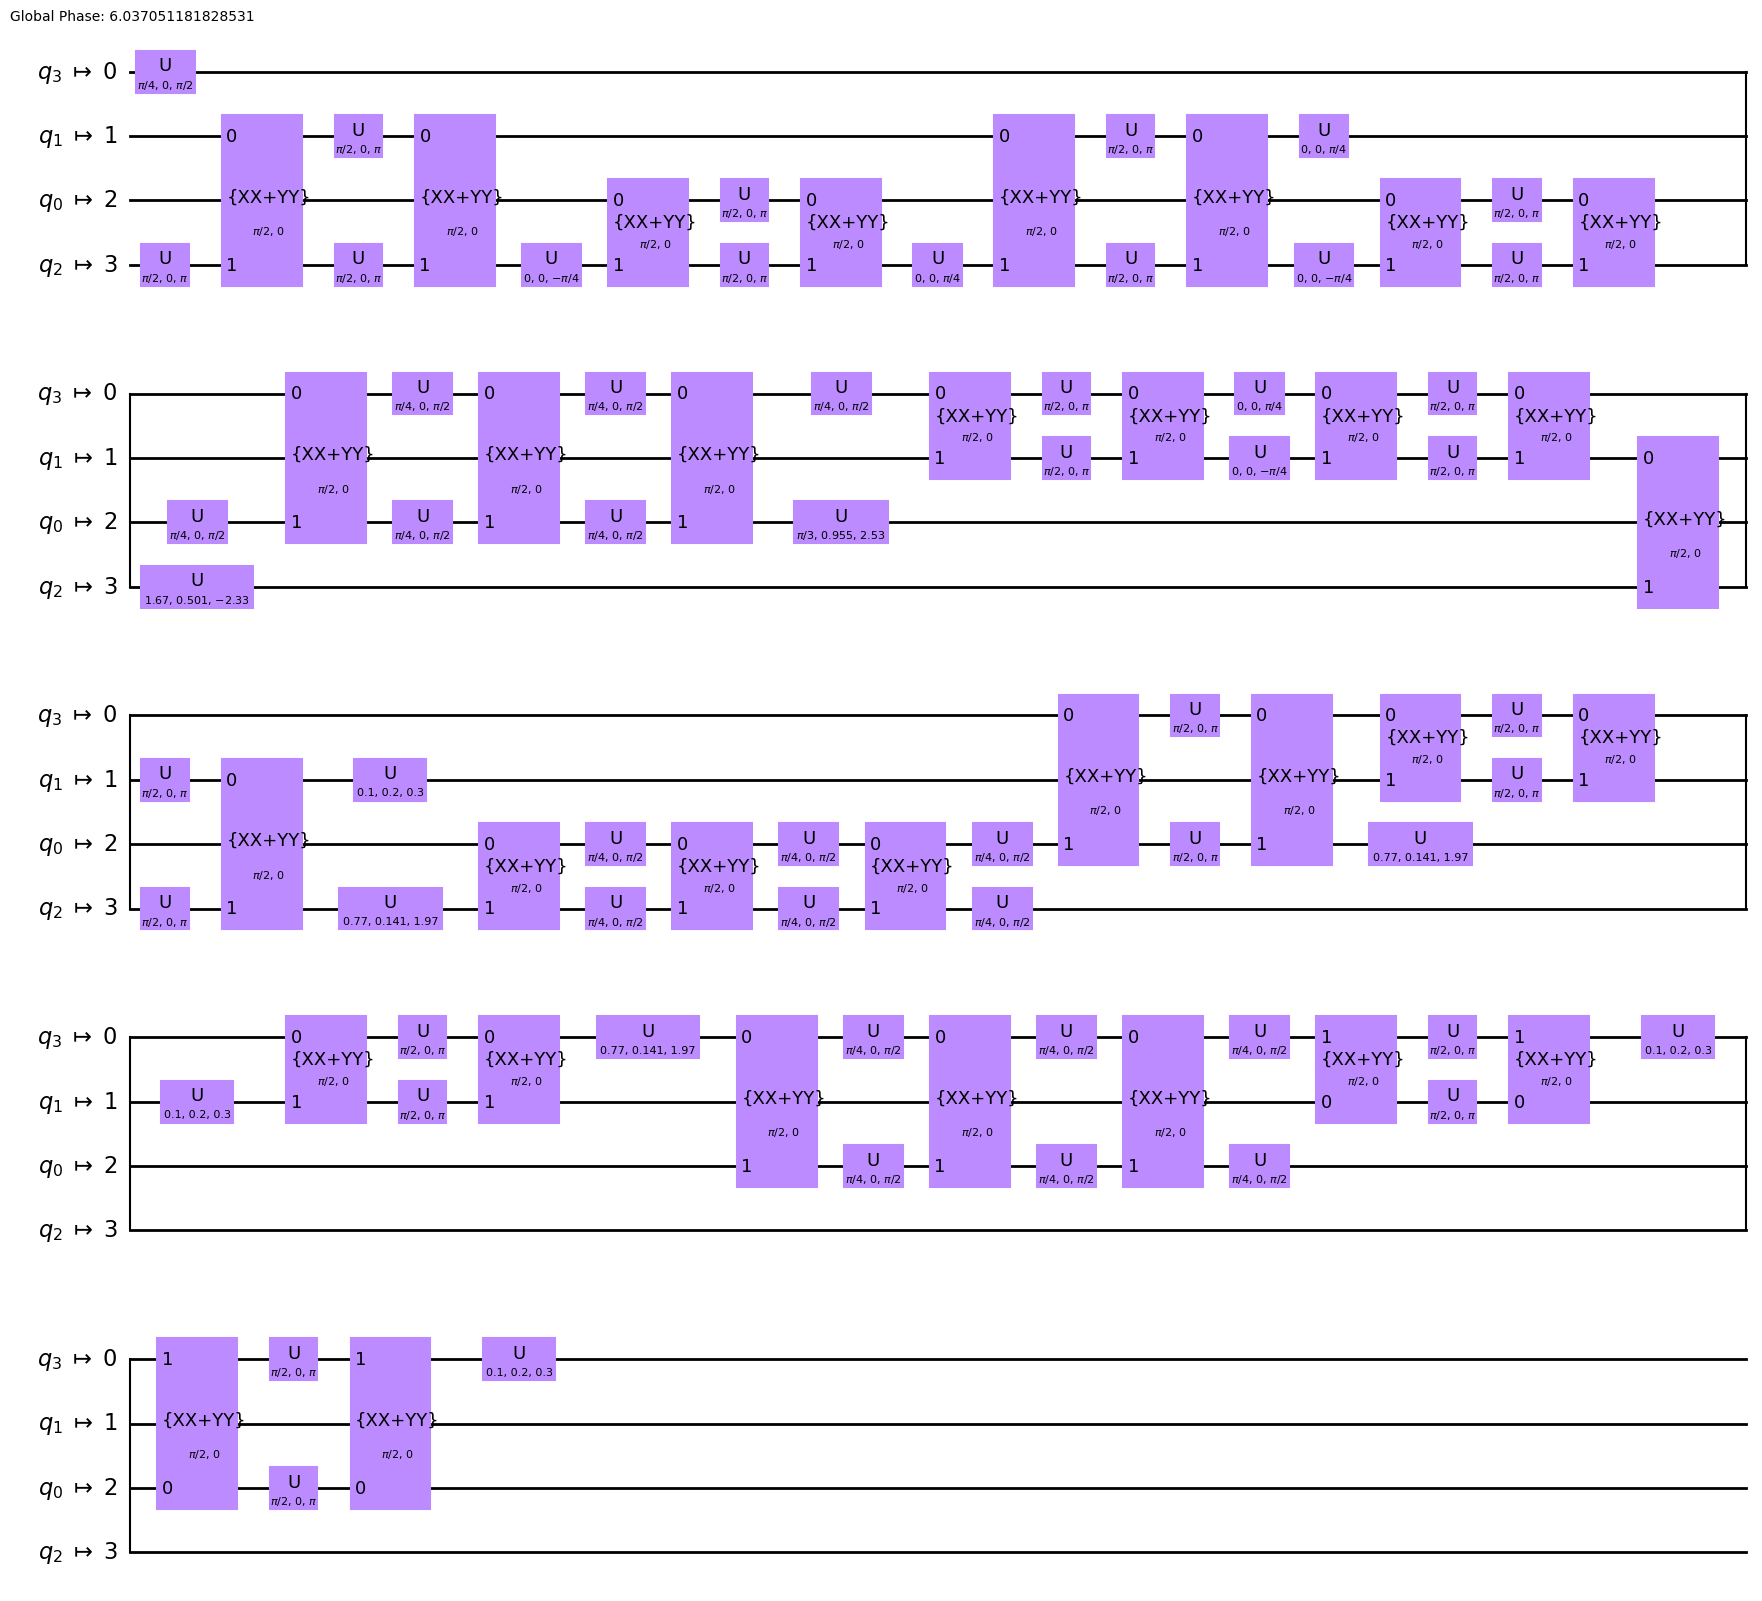

In [41]:
class iSwapDecompose(TransformationPass):
    def __init__(self):
        super().__init__()
    def run(self, dag):
        temp_dag = dag.copy_empty_like()
        # iterate over all nodes
        for node in dag.topological_op_nodes():
            # get coordinate
            if len(node.qargs)==2:
                coord = c1c2c3(Operator(node.op).data)
                # poor man's monodromy :)
                if coord == (0.5, 0.5, 0.5):
                    # 3 sqiswaps
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                # elif coord == (X, 0,0)
                elif coord[1] == 0.0 and coord[2] == 0.0:
                    # 2 sqiswap
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                elif coord == (0.5, 0.5, 0.0):
                    # 1 iswap
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                elif coord == (0.5, .25, .25):
                    # ECP => 2 sqiswap
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                elif coord == (0.25, 0.25, 0.0):
                    # 1 sqiswap
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), node.qargs)
                else:
                    print(coord)
                    raise ValueError('Unexpected decomp')
            else:
                temp_dag.apply_operation_back(node.op, node.qargs)
        return temp_dag
    
# consolidate all 2Qs
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks
pm = PassManager([Collect2qBlocks(), ConsolidateBlocks(force_consolidate=1), iSwapDecompose()])
# bb = pm.run(bb)
# pm = PassManager([iSwapDecompose()])
# num_ops = sum(bb.count_ops().values())
# count ops of xx_plus_yy gates
num_ops = bb.count_ops()['xx_plus_yy']
print('Number of operations:', num_ops)
bb.draw(output='mpl')

Number of SWAPs in baseline: 3


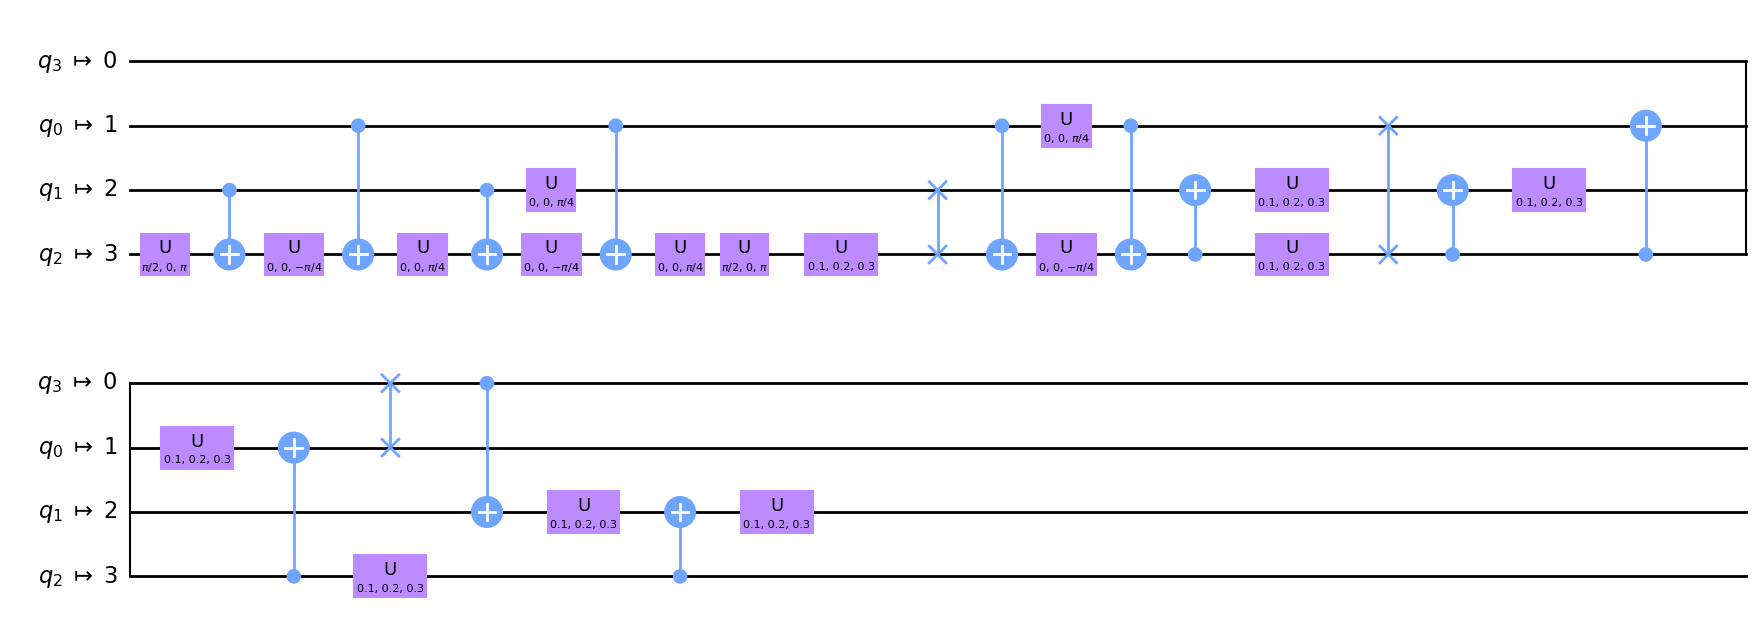

In [42]:
# induce baseline SWAPs
from qiskit.transpiler.passes import BasicSwap, SabreLayout, SabreSwap
pm = PassManager(passes=[SabreLayout(line_topo), SabreSwap(line_topo), OptimizeSwapBeforeMeasure()])
transp = pm.run(circ)
print('Number of SWAPs in baseline:', len([node for node in transp if node.operation.name == 'swap']))
transp.draw(output='mpl')

Number of SWAPs in baseline: 5


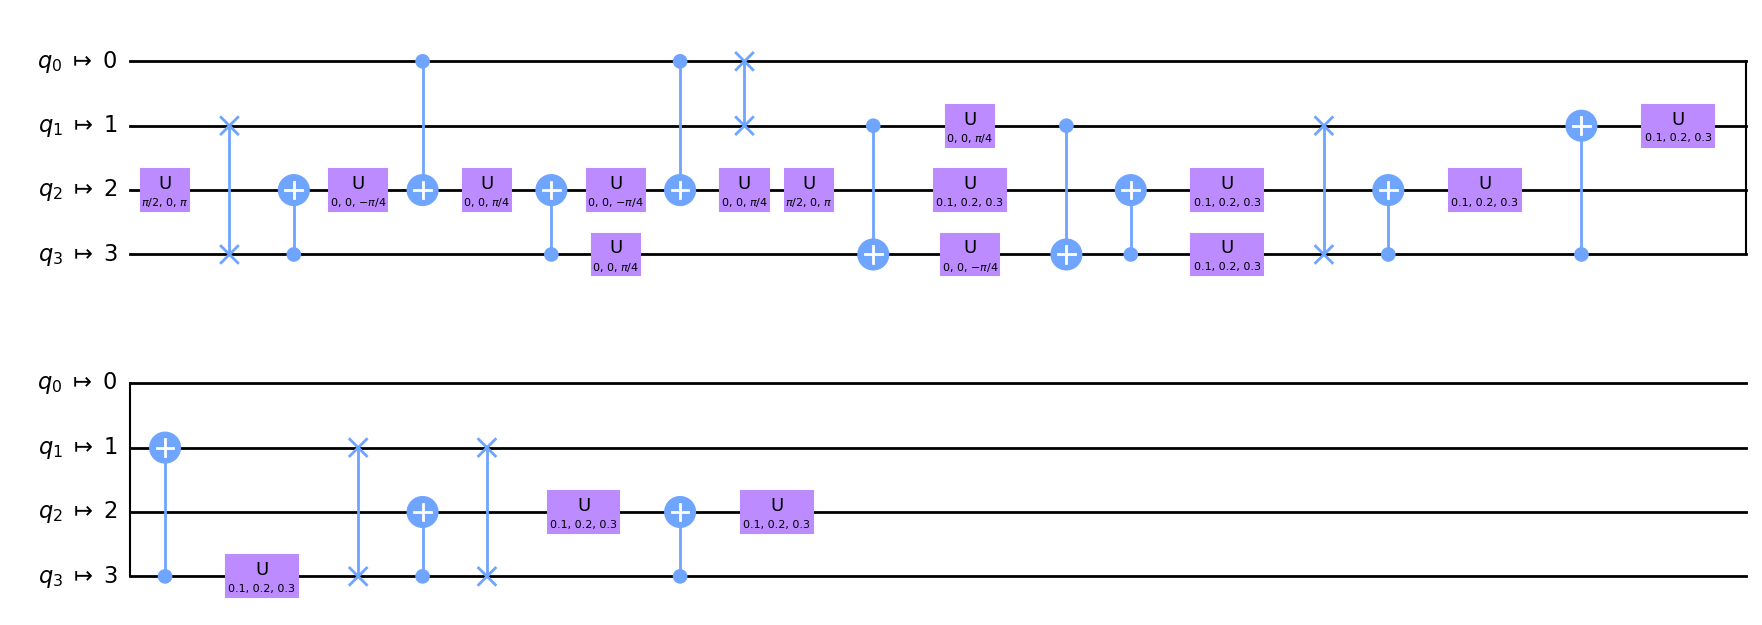

In [43]:
# finish with CNS sub
pm = PassManager(passes=[TrivialLayout(line_topo), BasicSwap(line_topo), CNSSubstitution(), OptimizeSwapBeforeMeasure()])
transp = pm.run(circ)
print('Number of SWAPs in baseline:', len([node for node in transp if node.operation.name == 'swap']))
transp.draw(output='mpl')

Number of sqiswap gates: 23


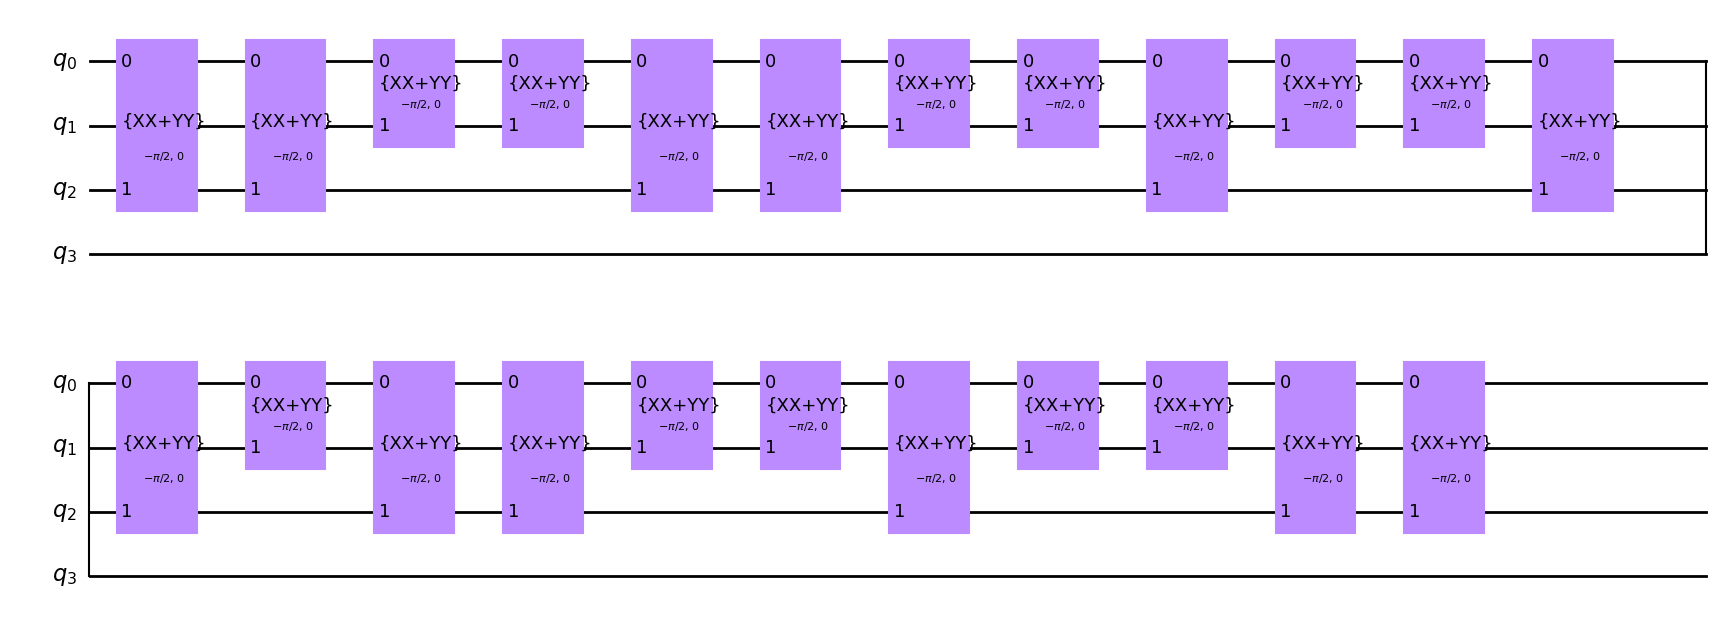

In [45]:
# more optimized (note not deterministic)
from qiskit.transpiler.passes import SabreLayout, SabreSwap, Collect2qBlocks, ConsolidateBlocks
# NOTE may need to rerun to be optimized for CNS -> hence the loop
min_cns_subs = None
for _ in range(20):
    pm = PassManager(passes=[SabreLayout(line_topo), SabreSwap(line_topo), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=1), CNSSubstitution(), OptimizeSwapBeforeMeasure(), iSwapDecompose()])
    if min_cns_subs is None:
        sabre_circ = pm.run(circ)
    else:
        sabre_circ = pm.run(min_circ)
    # count ops
    num_ops = sum(sabre_circ.count_ops().values())
    if min_cns_subs is None or num_ops < min_cns_subs:
        min_cns_subs = num_ops
        min_circ = sabre_circ

print('Number of sqiswap gates:', min_cns_subs)
# finally do the iSWAP decomposition
pm = PassManager(passes=[iSwapDecompose()])
min_circ = pm.run(min_circ)
min_circ.draw(output='mpl')

In [38]:
# draw dag
dag = circuit_to_dag(min_circ)
dag.draw()
# save as png
dag.draw(filename='dag.png')

In [15]:
# make VSwap substitution everywhere
pm = PassManager(passes=[TrivialLayout(line_topo), VSwapSubstitution(), SabreSwap(line_topo), OptimizeSwapBeforeMeasure()])
transp = pm.run(circ)
print('Number of SWAPs in baseline:', len([node for node in transp if node.operation.name == 'swap']))
transp.draw()

thread 'thread 'thread '<unnamed><unnamed>' panicked at '' panicked at '<unnamed>index out of bounds: the len is 4 but the index is 18446744073709551615index out of bounds: the len is 4 but the index is 18446744073709551615' panicked at '', ', index out of bounds: the len is 4 but the index is 18446744073709551615src/sabre_swap/layer.rssrc/sabre_swap/layer.rs', ::src/sabre_swap/layer.rs136136:::1362828:

28note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace

thread '<unnamed>' panicked at 'index out of bounds: the len is 4 but the index is 18446744073709551615', src/sabre_swap/layer.rs:136:28


PanicException: index out of bounds: the len is 4 but the index is 18446744073709551615

In [ ]:
#what is coordinate of iswap+iswap
qc = QuantumCircuit(2)
qc.iswap(0,1)
qc.u(.1, .2, .3, 0)
qc.swap(0,1)
print(c1c2c3(Operator(qc).data))

(0.5, 0.0, 0.0)


In [ ]:
# smarter version should choose between iSWAP and VSWAP

class Lookahead_VSwapSubstitution(TransformationPass):
    """Substitute CX with iSwap+VSwap"""
    def __init__(self, topology:CouplingMap):
        super().__init__()
        self.topology = topology

    def check_if_better_layout(self, dag, layout_dict, node):
        # NOTE helpful reference https://qiskit.org/documentation/_modules/qiskit/transpiler/passes/routing/lookahead_swap.html#LookaheadSwap
        # check if accepting a VSWAP will result in a better layout
        # if so, accept it
        # TODO

        # first find the operators that come after the CX
        sucs = list(dag.quantum_successors(node))
        # if there are no successors, then we can accept the VSWAP
        if len(sucs) == 0:
            return True

        # if len <= 1, and suc is a SWAP then we can accept the VSWAP (same as CNS sub)
        if len(sucs) == 1 and sucs[0].name == 'swap':
            return True
        
        # only keep opnodes, don't want OutNode successors
        sucs = [suc for suc in sucs if isinstance(suc, DAGOpNode)]
        
        accept_dist = 0
        reject_dist = 0
        for suc in sucs:
            
            suc_bits = [layout_dict[q] for q in suc.qargs]
            node_bits = [layout_dict[q] for q in node.qargs]

            # convert qubit to physical index
            suc_bits = [q.register.index(q) for q in suc_bits]
            node_bits = [q.register.index(q) for q in node_bits]

            # if reject, calculate distance of each successor to the CX
            for suc_bit, node_bit in zip(suc_bits, node_bits):
                reject_dist += self.topology.distance(suc_bit, node_bit)

            # if accept, calculate distance where node_bits have been swapped
            for suc_bit, node_bit in zip(suc_bits, reversed(node_bits)):
                accept_dist += self.topology.distance(suc_bit, node_bit)

        if accept_dist < reject_dist:
            return True
        else:
            return False

    def run(self, dag):
        temp_dag = dag.copy_empty_like()
        layout_dict = {qubit: qubit for qubit in dag.qubits}

        for node in dag.topological_op_nodes():
            # if node is a CX, substitute with iSwap+VSwap
            # and update layout_dict
            qargs = [layout_dict[q] for q in node.qargs]

            if node.name == 'cx' or c1c2c3(Operator(node.op).data) == (0.5, 0.0, 0.0):
                ### ACCEPT LOGIC HERE ###
                if self.check_if_better_layout(dag, layout_dict, node):

                    # temp_dag.apply_operation_back(self.sub, qargs)
                    # temp_dag.apply_operation_back(RZGate(-np.pi/2), qargs[:1])
                    # temp_dag.apply_operation_back(HGate(), qargs[1:])
                    # temp_dag.apply_operation_back(RZGate(-np.pi/2), qargs[1:])
                    temp_dag.apply_operation_back(iSwapGate(), qargs)
                    # temp_dag.apply_operation_back(HGate(), qargs[:1])

                    # swap qubits in layout_dict
                    layout_dict[node.qargs[1]], layout_dict[node.qargs[0]] = qargs

                else:
                    # otherwise, accept 2sqiswap decomposition
                    # XXX missing 1Q gates for now, for simplicity
                    # temp_dag.apply_operation_back(iSwapGate(), qargs)
                    # temp_dag.apply_operation_back(iSwapGate().power(1/2), qargs)
                    temp_dag.apply_operation_back(iSwapGate().power(1/2), qargs)
            
            # otherwise, add node to temp_dag using layout_dict
            else:
                temp_dag.apply_operation_back(node.op, qargs)
                
        return temp_dag

In [ ]:
# 1 Step Lookahead
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks
pm0 = PassManager([Collect2qBlocks(), ConsolidateBlocks(force_consolidate=1)])
transp0 = pm0.run(circ)
pm = PassManager([TrivialLayout(line_topo), Lookahead_VSwapSubstitution(line_topo), SabreSwap(line_topo), OptimizeSwapBeforeMeasure()])
transp = pm.run(transp0)
print('Number of SWAPs in baseline:', len([node for node in transp if node.operation.name == 'swap']))
transp.draw()

NameError: name 'SabreSwap' is not defined

In [ ]:
# smarter version should choose between iSWAP and VSWAP
import random

class Anneal_VSwapSubstitution(TransformationPass):
    """Substitute 1 random CX with iSwap+VSwap
    Assumes # CXs >> # SA iters (so don't run out of CXs)
    """
    def __init__(self, topology:CouplingMap, T=1.0):
        super().__init__()
        self.topology = topology
        self.T = T

    def run(self, dag):
        temp_dag = dag.copy_empty_like()
        layout_dict = {qubit: qubit for qubit in dag.qubits}

        # ahead of time need to randomly select a CX to substitute
        # for all op_nodes, grab a random CX
        cxs = [node for node in dag.topological_op_nodes() if len(node.qargs)==2 and c1c2c3(Operator(node.op).data) == (0.5, 0.0, 0.0)]
        marked_cx = random.choice(cxs)
        # hardcode 
        # marked_cx = cxs[0]

        for node in dag.topological_op_nodes():
            # if node is a CX, substitute with iSwap+VSwap
            # and update layout_dict
            qargs = [layout_dict[q] for q in node.qargs]

            if node == marked_cx:
                    
                # temp_dag.apply_operation_back(self.sub, qargs)
                # temp_dag.apply_operation_back(RZGate(-np.pi/2), qargs[:1])
                # temp_dag.apply_operation_back(HGate(), qargs[1:])
                # temp_dag.apply_operation_back(RZGate(-np.pi/2), qargs[1:])
                temp_dag.apply_operation_back(iSwapGate(), qargs)
                # temp_dag.apply_operation_back(HGate(), qargs[:1])

                # swap qubits in layout_dict
                layout_dict[node.qargs[1]], layout_dict[node.qargs[0]] = qargs

            # otherwise, add node to temp_dag using layout_dict
            else:
                temp_dag.apply_operation_back(node.op, qargs)
                # XXXX here could turn CX into 2 sqiswaps if want to
                
        return temp_dag

In [ ]:
# annealing
from qiskit.transpiler.passes import SabreLayout, SabreSwap, StochasticSwap
# NOTE may need to rerun to be optimized for CNS -> hence the loop
min_cns_subs = None
pm = PassManager(passes=[TrivialLayout(line_topo), SabreSwap(line_topo), CNSSubstitution(), OptimizeSwapBeforeMeasure()])
sabre_circ = pm.run(circ)

print(sabre_circ.draw())
base_swaps = len([node for node in sabre_circ if node.operation.name == 'swap'])
print('Number of SWAPs:', base_swaps)


# outline
# randomly pick a CX and make VSwap substitution
# calculate cost function
# if cost function is lower, accept
# else, accept with probability e^(-delta_cost/T)
# T = 1.0

T = 1.0
for i in range(20):
    # print('T =', T)
    # make sub, then induce swaps as necessary
    pm = PassManager(passes=[Anneal_VSwapSubstitution(line_topo, T=T), StochasticSwap(line_topo), CNSSubstitution(), OptimizeSwapBeforeMeasure()])
    transp = pm.run(sabre_circ)
    print(transp.draw())
    num_swaps = len([node for node in transp if node.operation.name == 'swap'])
    print('Number of SWAPs:', num_swaps)

    # compare num_swaps to base_swaps
    if num_swaps < base_swaps:
        print('ACCEPTED')
        base_swaps = num_swaps
        sabre_circ = transp
    else:
        if base_swaps == 0:
            print("DONE")
            break
        # accept with probability e^(-delta_cost/T)
        delta_cost = num_swaps - base_swaps
        if random.random() < np.exp(-delta_cost/T): #starting with too low accept p, start with T=4.0 ?
            print('ACCEPTED')
            base_swaps = num_swaps
            sabre_circ = transp
        else:
            print('NOT ACCEPTED')

    T *= 0.9 # XXX could be cooling too fast, might need to go many times before cooling

                                                                ┌───┐       »
q_0 -> 0 ──────────────────────────────────────────X────────────┤ X ├───────»
                                ┌────────────────┐ │            └─┬─┘       »
q_1 -> 1 ────────────────────■──┤ U(0.1,0.2,0.3) ├─X───■──────────■─────────»
         ┌────────────────┐┌─┴─┐├────────────────┤   ┌─┴─┐┌────────────────┐»
q_2 -> 2 ┤ U(0.1,0.2,0.3) ├┤ X ├┤ U(0.1,0.2,0.3) ├───┤ X ├┤ U(0.1,0.2,0.3) ├»
         └────────────────┘└───┘└────────────────┘   └───┘└────────────────┘»
q_3 -> 3 ───────────────────────────────────────────────────────────────────»
                                                                            »
«         ┌────────────────┐┌───┐                                            »
«q_0 -> 0 ┤ U(0.1,0.2,0.3) ├┤ X ├───────────────────────■────────────────────»
«         └────────────────┘└─┬─┘┌────────────────┐   ┌─┴─┐┌────────────────┐»
«q_1 -> 1 ────────────────────■──┤ U(0.1,0.2,0.3) ├─X─┤ X ├┤ 

In [ ]:
sabre_circ.draw()

┌────────┐    »
q_0: ──────────────────────────────────────────X──────────┤1       ├────»
                            ┌────────────────┐ │          │  Iswap │    »
q_1: ────────────────────■──┤ U(0.1,0.2,0.3) ├─X───■──────┤0       ├────»
     ┌────────────────┐┌─┴─┐├────────────────┤   ┌─┴─┐┌───┴────────┴───┐»
q_2: ┤ U(0.1,0.2,0.3) ├┤ X ├┤ U(0.1,0.2,0.3) ├───┤ X ├┤ U(0.1,0.2,0.3) ├»
     └────────────────┘└───┘└────────────────┘   └───┘└────────────────┘»
q_3: ───────────────────────────────────────────────────────────────────»
                                                                        »
«                            ┌────────────────┐                             »
«q_0: ────────────────────■──┤ U(0.1,0.2,0.3) ├─X──────■────────────────────»
«     ┌────────────────┐┌─┴─┐└────────────────┘ │    ┌─┴─┐┌────────────────┐»
«q_1: ┤ U(0.1,0.2,0.3) ├┤ X ├───────────────────X──X─┤ X ├┤ U(0.1,0.2,0.3) ├»
«     └────────────────┘└───┘                      │ └───┘└────────────────┘»
«q_2: ─────────────────────────────────────────────X────────────────────────»
«                                                                           »
«q_3: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«                                 
«q_0: ────────────────────────────
«     ┌────────┐                  
«q_1: ┤1       ├──────────────────
«     │  Iswap │┌────────────────┐
«q_2: ┤0       ├┤ U(0.1,0.2,0.3) ├
«     └────────┘└────────────────┘
«q_3: ────────────────────────────
«